<a href="https://colab.research.google.com/github/chhandak72/spam-filtering/blob/main/spamfiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
#Reading CSV file
#https://www.kaggle.com/uciml/sms-spam-collection-dataset
data=pd.read_csv('spam.csv',encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)#dropping unnecessary data
#Changing column name v1 to label and v2 to message

data = data.rename(columns={"v1":"label", "v2":"message"})
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#How many labels are ham and spam
data['label'].value_counts()

,count
label,
ham,4825
spam,747


In [5]:
#Changing the label values ham: 1 and spam : 0
def partition(x):
    if x=='ham':
        return 1
    else:
        return 0

actualScore=data['label']
hamSpam=actualScore.map(partition)
data['label']=hamSpam
data.head()

,label,message
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#removing stopwords and Data Cleaning
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
#All Stopwords
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [8]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_message = []
# tqdm is for printing the status bar
for sentance in tqdm(data['message'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_message.append(sentance.strip())

100%|██████████| 5572/5572 [00:01<00:00, 3773.92it/s]


In [9]:
preprocessed_message[1000]

'no heard abt tat'

In [10]:
import math
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
#Applying Multinomial Naive Bayes for Spam Filtering
#Featurization BAG OF WORDS

#First split data into train and test

X=preprocessed_message

y=np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(y_train.shape)
print(y_test.shape)

(3900,)
(1672,)
(3900,)
(1672,)


In [11]:
count_vect=CountVectorizer()
X_train=count_vect.fit_transform(X_train)
X_test=count_vect.transform(X_test)

alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5
cv_scores = []

# perform 10-fold cross validation
for k in alpha_values:
    mnb = MultinomialNB(alpha = k)
    scores = cross_val_score(mnb, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

# determining best value of alpha
optimal_alpha = alpha_values[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 10.000.


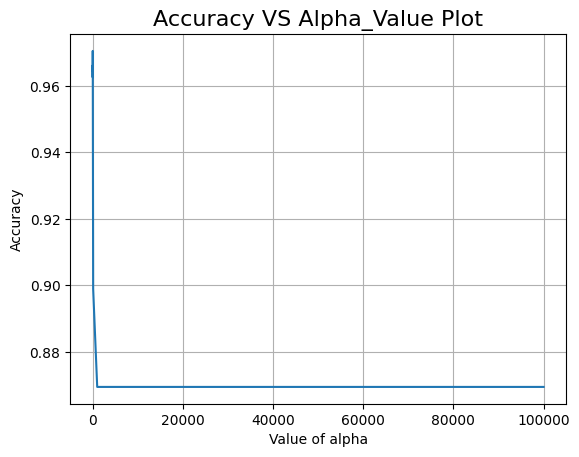



Alpha values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

Accuracy for each alpha value is :
  [0.96462 0.96513 0.9659  0.96615 0.96359 0.96256 0.97051 0.89897 0.86949
 0.86949 0.86949]


In [12]:
# plot accuracy vs alpha
plt.plot(alpha_values, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",alpha_values)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [13]:
# instantiate learning model alpha = optimal_alpha
mnb = MultinomialNB(alpha = optimal_alpha)

# fitting the model
mnb.fit(X_train, y_train)

# predict the response
predictions = mnb.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, predictions) * 100
print('\nThe Test Accuracy of the Bernoulli naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))


The Test Accuracy of the Bernoulli naive Bayes classifier for alpha = 10.000 is 96.052632%


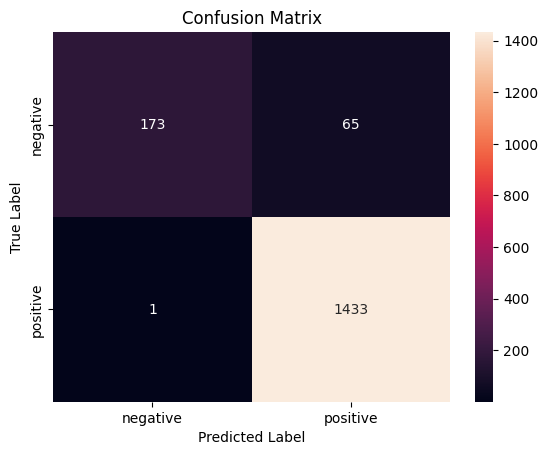

In [14]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=optimal_alpha)
mnb.fit(X_train,y_train)
predic=mnb.predict(X_test)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [15]:
#Let's try for tfidf


X=preprocessed_message

y=np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

tf_idf_vect = TfidfVectorizer(min_df=10)
X_train=tf_idf_vect.fit_transform(X_train)
X_test=tf_idf_vect.transform(X_test)

alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5
cv_scores = []

# perform 10-fold cross validation
for k in alpha_values:
    mnb = MultinomialNB(alpha = k)
    scores = cross_val_score(mnb, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

# determining best value of alpha
optimal_alpha = alpha_values[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.100.
